## Portfolio Part 3

In this Portfolio task, you will continue working with the dataset you have used in portfolio 2. But the difference is that the rating column has been changed with like or dislike values. Your task is to train classification models to predict whether a user like or dislike an item.  


The header of the csv file is shown below. 

| userId | timestamp | review | item| rating | helpfulness | gender | category |
    | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | 
    
#### Description of Fields

* __userId__ - the user's id
* __timestamp__ - the timestamp indicating when the user rated the shopping item
* __review__ - the user's review comments of the item
* __item__ - the name of the item
* __rating__ - the user like or dislike the item
* __helpfulness__ - average rating from other users on whether the review comment is helpful. 6-helpful, 0-not helpful. 
* __gender__ - the gender of the user, F- female, M-male
* __category__ - the category of the shopping item


Your high level goal in this notebook is to try to build and evaluate predictive models for 'rating' from other available features - predict the value of the __rating__ field in the data from some of the other fields. More specifically, you need to complete the following major steps: 
1) Explore the data. Clean the data if necessary. For example, remove abnormal instanaces and replace missing values.
2) Convert object features into digit features by using an encoder
3) Study the correlation between these features. 
4) Split the dataset and train a logistic regression model to predict 'rating' based on other features. Evaluate the accuracy of your model.
5) Split the dataset and train a KNN model to predict 'rating' based on other features. You can set K with an ad-hoc manner in this step. Evaluate the accuracy of your model.
6) Tune the hyper-parameter K in KNN to see how it influences the prediction performance

Note 1: We did not provide any description of each step in the notebook. You should learn how to properly comment your notebook by yourself to make your notebook file readable. 

Note 2: you are not being evaluated on the ___accuracy___ of the model but on the ___process___ that you use to generate it. Please use both ___Logistic Regression model___ and ___KNN model___ for solving this classification problem. Accordingly, discuss the performance of these two methods.

In [274]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import DecisionBoundaryDisplay


sns.set_theme()
%matplotlib inline

warnings.filterwarnings('ignore')


In [275]:
df = pd.read_csv('files/Portfolio 3.csv')
df.head(10)


,userId,timestamp,review,item,rating,helpfulness,gender,category
0,4259,11900,"Finally, Something for (Relatively) Nothing",MyPoints.com,like,4,F,Online Stores & Services
1,4259,12000,Shocking!,Sixth Sense,like,4,F,Movies
2,4259,12000,Simply Shaggadelic!,Austin Powers: The Spy Who Shagged Me,like,4,F,Movies
3,4259,12000,Better Than The First!,Toy Story 2,like,3,F,Movies
4,4259,12000,Blair Witch made me appreciate this,Star Wars Episode I: The Phantom Menace,dislike,4,F,Movies
5,4259,12100,Come here at least once in your life... stay a...,New York City,like,4,F,Hotels & Travel
6,4259,12400,"I joined for the free camera, and stood for no...",Earthlink,like,3,F,Online Stores & Services
7,4259,12700,They Should've Fooled the American Public,Blair Witch Project,dislike,4,F,Movies
8,4259,51600,A Short List of Things to Remember in NYC,New York City,like,4,F,Hotels & Travel
9,4259,60200,Do you know what a metaphysical can of worms t...,Being John Malkovich,like,4,F,Movies


### Explore the Dataset

In [276]:
# shape
df.shape


(2899, 8)

In [277]:
# info
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2899 entries, 0 to 2898
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   userId       2899 non-null   int64 
 1   timestamp    2899 non-null   int64 
 2   review       2899 non-null   object
 3   item         2899 non-null   object
 4   rating       2899 non-null   object
 5   helpfulness  2899 non-null   int64 
 6   gender       2899 non-null   object
 7   category     2899 non-null   object
dtypes: int64(3), object(5)
memory usage: 181.3+ KB


As it can be seen, there is no null value in the dataset because all the columns are 2899 counts with non-null.

In [278]:
# descriptive statistics
df.describe()


,userId,timestamp,helpfulness
count,2899.000000,2899.000000,2899.000000
mean,5430.148672,56403.285271,3.875474
std,3460.227028,37664.826368,0.330237
min,46.000000,10100.000000,3.000000
25%,1676.000000,20500.000000,4.000000
50%,5985.000000,52101.000000,4.000000
75%,8626.000000,82500.000000,4.000000
max,10815.000000,123199.000000,4.000000


### Encode Categorical features

Text(0.5, 1.0, 'Review count for each category')

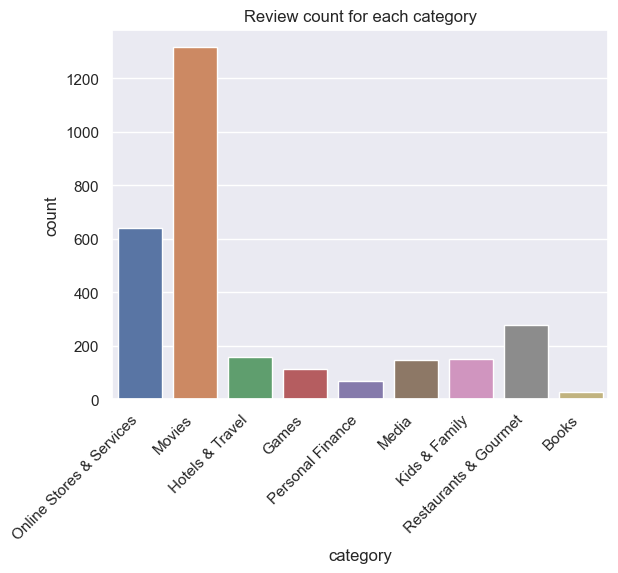

In [279]:
# plot number of review for each category
category_plot = sns.countplot(x=df['category'], label='Count')
category_plot.set_xticklabels(category_plot.get_xticklabels(),
                              rotation=45,
                              horizontalalignment='right')
category_plot.set_title('Review count for each category')


In [280]:
ord_enc = OrdinalEncoder()

# encode category feature
df['category_code'] = ord_enc.fit_transform(df[['category']])
df[['category', 'category_code']].head(10)


,category,category_code
0,Online Stores & Services,6.0
1,Movies,5.0
2,Movies,5.0
3,Movies,5.0
4,Movies,5.0
5,Hotels & Travel,2.0
6,Online Stores & Services,6.0
7,Movies,5.0
8,Hotels & Travel,2.0
9,Movies,5.0


Text(0.5, 1.0, 'Review count by each gender')

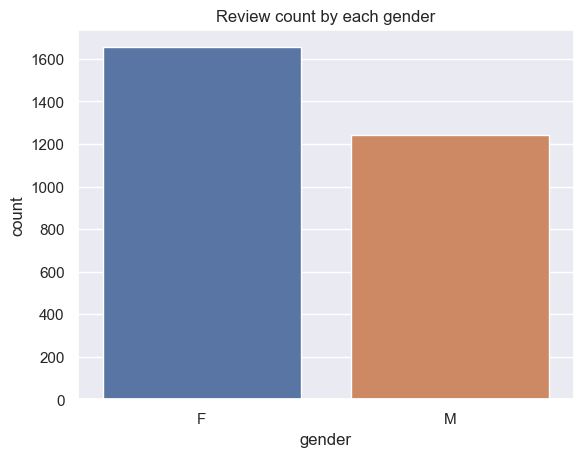

In [281]:
sns.countplot(x=df['gender'], label='Count').set_title(
    'Review count by each gender')


In [282]:
# encode gender value
df['gender_code'] = ord_enc.fit_transform(df[['gender']])
df[['gender', 'gender_code']].tail(10)


,gender,gender_code
2889,M,1.0
2890,M,1.0
2891,M,1.0
2892,F,0.0
2893,F,0.0
2894,F,0.0
2895,F,0.0
2896,F,0.0
2897,F,0.0
2898,F,0.0


In [283]:
# encode review value
df['review_code'] = ord_enc.fit_transform(df[['review']])
df[['review', 'review_code']].tail(10)


,review,review_code
2889,EBAY TAKES MY PAY ???,739.0
2890,Sophia Loves The Teletubbies ???,2048.0
2891,My Pal is Pay Pal,1617.0
2892,one word....Sick!,2835.0
2893,In the eye of the beholder,1311.0
2894,I dare you to sleep through this soon to be cl...,1221.0
2895,Another movie to keep us out of the water!!!!,379.0
2896,Miles above other films.,1546.0
2897,This could be the beginning of a comedy era.,2431.0
2898,Maybe it should have been cut?,1519.0


Text(0.5, 1.0, 'Review count by each rating')

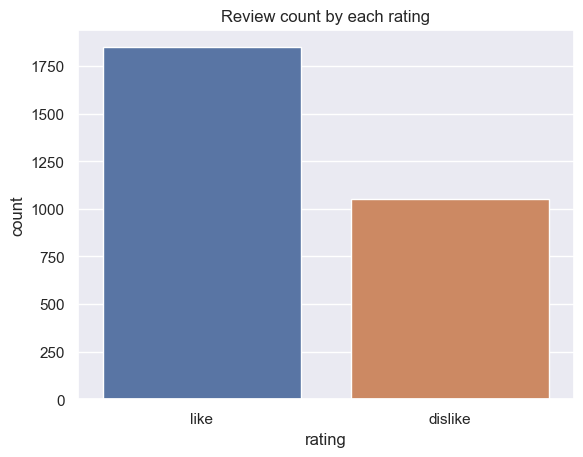

In [284]:
sns.countplot(x=df['rating'], label='Count').set_title(
    'Review count by each rating')


In [285]:
# encode rating value
df['rating_code'] = ord_enc.fit_transform(df[['rating']])
df[['rating', 'rating_code']].tail(10)


,rating,rating_code
2889,like,1.0
2890,like,1.0
2891,like,1.0
2892,dislike,0.0
2893,dislike,0.0
2894,like,1.0
2895,like,1.0
2896,like,1.0
2897,dislike,0.0
2898,dislike,0.0


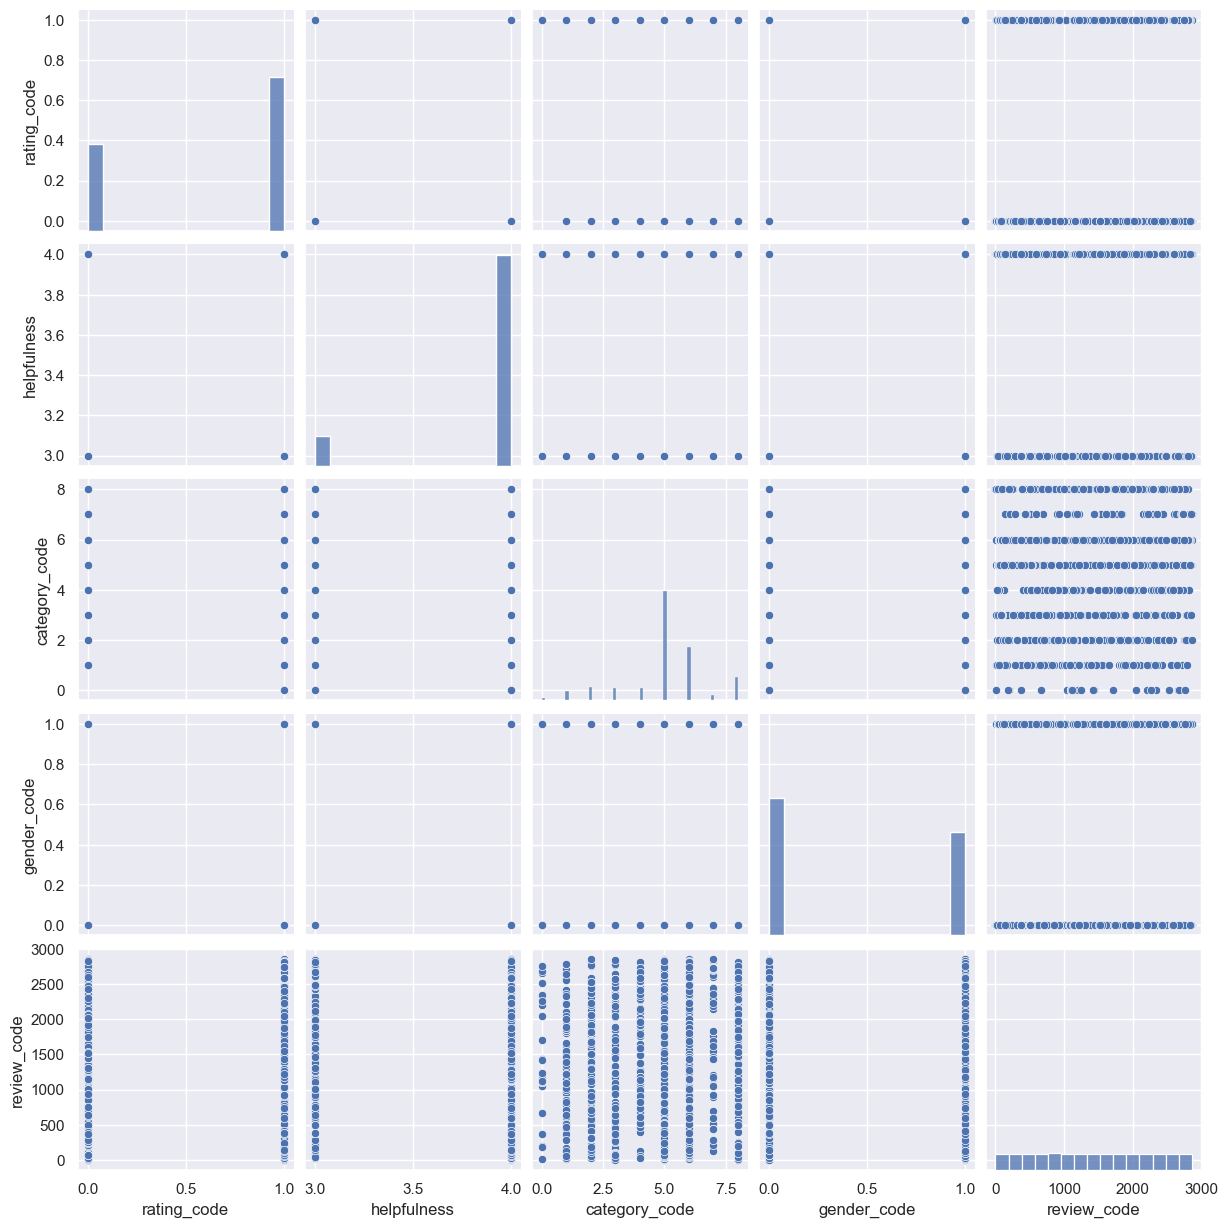

In [286]:
# pairpolot
sns.pairplot(data=df, vars=[
             'rating_code', 'helpfulness', 'category_code', 'gender_code', 'review_code'])


### Explore the correlation

In [287]:
df.corr()


,userId,timestamp,helpfulness,category_code,gender_code,review_code,rating_code
userId,1.000000,-0.036399,-0.016841,0.015408,0.056183,0.013212,0.010844
timestamp,-0.036399,1.000000,0.003638,0.037118,-0.049244,-0.025036,0.011579
helpfulness,-0.016841,0.003638,1.000000,-0.000189,-0.046627,0.016170,-0.016850
category_code,0.015408,0.037118,-0.000189,1.000000,-0.017644,0.012047,-0.116312
gender_code,0.056183,-0.049244,-0.046627,-0.017644,1.000000,-0.014422,0.022576
review_code,0.013212,-0.025036,0.016170,0.012047,-0.014422,1.000000,-0.046935
rating_code,0.010844,0.011579,-0.016850,-0.116312,0.022576,-0.046935,1.000000


<AxesSubplot: >

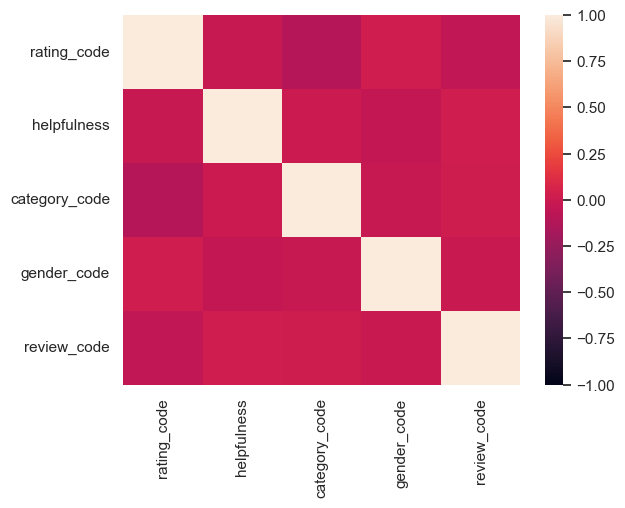

In [288]:
sns.heatmap(data=df[['rating_code', 'helpfulness', 'category_code', 'gender_code', 'review_code']
                    ].corr(), vmax=1, vmin=-1)


In [289]:
# compare absolute value of correlation to find most and least correlated pair with rating_code
rating_correlated = df[['rating_code', 'helpfulness', 'category_code', 'gender_code', 'review_code']
                       ].corr().rating_code.abs().sort_values().reset_index().drop(index=4).rename({'index': 'feature', 'rating_code': 'correlation'}, axis=1)
rating_correlated


,feature,correlation
0,helpfulness,0.016850
1,gender_code,0.022576
2,review_code,0.046935
3,category_code,0.116312


Text(0.5, 1.0, 'Comparision between Correlation of four Features regarding Rating')

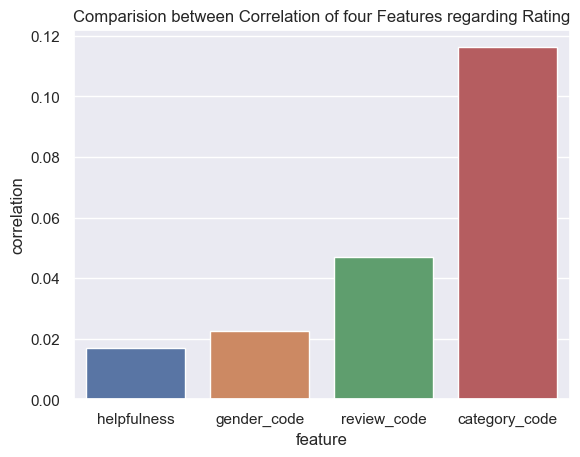

In [290]:
sns.barplot(data=rating_correlated, x='feature', y='correlation').set_title(
    'Comparision between Correlation of four Features regarding Rating')


**Comment:** The correlation in this dataset is low, with category_code is the highest correlated feature regards to rating_code, at 0.11. When using this data to train and evaluate models, it is expected that the models may have poor accuracy in terms of predicting rating_code based on input features.

### Logistic Regression

In this part, we will build a logistic regression model to predict the **rating_code** of each review from the dataset. We will first split our Epinion dataset into training and testing data, then use the training set to fit our model. Afterthat, we will evaluate the model using train data before use it to make prediction on the test set. Finally, we will evaluate the model by comparing the prediction vs actual data.

#### Split training/testing data

Split the dataset into training set (80%) and testing set (20%).

In [291]:
# Split data into training(80%) and testing data (20%) and use random_state=142
train, test = train_test_split(df, test_size=0.2, random_state=142)
print('Shape of training and testing set:', train.shape, test.shape)

input_features = ['helpfulness', 'category_code', 'gender_code', 'review_code']
target_feature = 'rating_code'

X_train = train[input_features]
y_train = train[target_feature]
X_test = test[input_features]
y_test = test[target_feature]


Shape of training and testing set: (2319, 12) (580, 12)


In [292]:
train.rating.value_counts()


like       1474
dislike     845
Name: rating, dtype: int64

In [294]:
test.rating.value_counts()


like       375
dislike    205
Name: rating, dtype: int64

Text(0.5, 0.98, 'Like-dislike proportion of Train-Test data set')

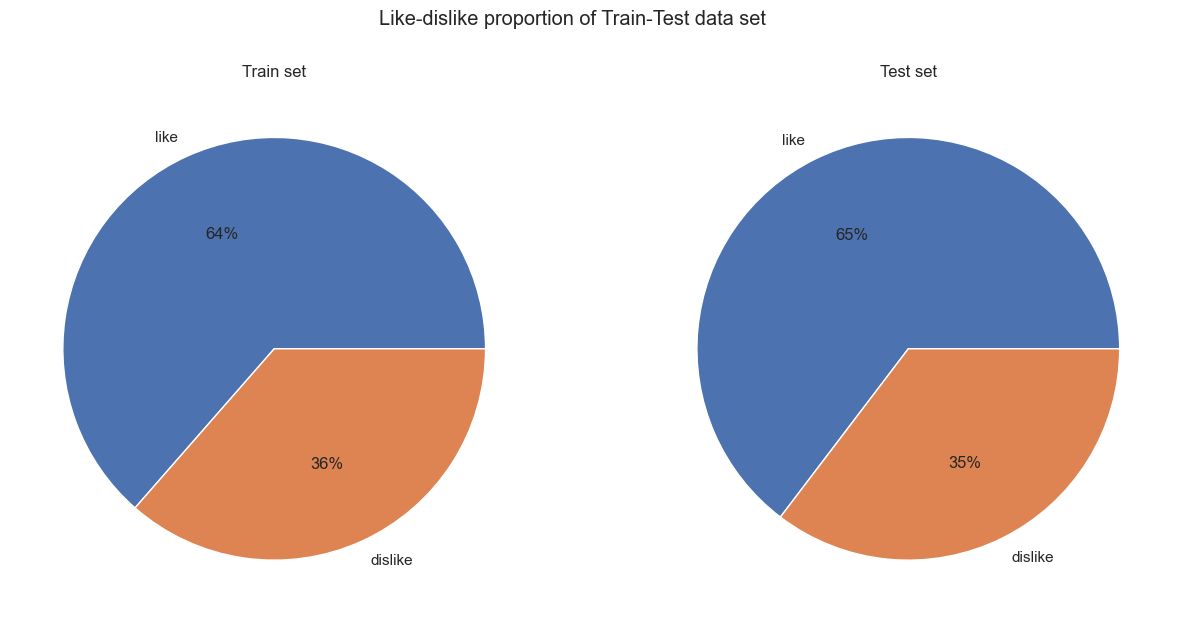

In [320]:
plt.figure(figsize=[15, 7])
plt.subplot(1,2,1)
plt.pie(x=train.rating.value_counts(), labels=[
        'like', 'dislike'], autopct='%.0f%%')
plt.title('Train set')

plt.subplot(1,2,2)
plt.pie(x=test.rating.value_counts(), labels=[
        'like', 'dislike'], autopct='%.0f%%')
plt.title('Test set')
plt.suptitle('Like-dislike proportion of Train-Test data set')


**Comment:** There are far more like ratings than dislike ratings. In this case, the train and test dataset is referred to as *unbalanced*.

#### Train the model

Train and evaluate the logistic regression model using training data.

In [296]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
print('coef=', log_model.coef_)
print('intercept=', log_model.intercept_)
print('classes', log_model.classes_)


coef= [[ 3.15658595e-01 -1.43081575e-01  4.73609592e-02 -4.25632292e-05]]
intercept= [0.09053123]
classes [0. 1.]


#### Evaluate Regression model

##### Accuracy

In [297]:
train_predicted = log_model.predict(X_train)
test_predicted = log_model.predict(X_test)
accuracy_scores = []
train_score = log_model.score(X_train, y_train)
print("Accuracy score on training set: ",
      train_score)

accuracy_scores.append(['Logistic Regresion', train_score, 'training'])

test_score = log_model.score(X_test, y_test)
print("Accuracy score on testing set: ",
      test_score)
accuracy_scores.append(['Logistic Regresion', test_score, 'testing'])


Accuracy score on training set:  0.6317378180250108
Accuracy score on testing set:  0.6482758620689655


**Comment:** As stated above, the training and testing set are *unbalanced*. In our case, we see that accuracy on training (0.63) and testing (0.64) set are really close to the distribution of the like-dislike in the two set, 64%-36% for train and 65-35% for testing data.

In particular, always predict the majority class, **like** in this case, will give us about 64% accuracy. We can examine the confusion matrix to see if it's the case.

##### Confusion Matrix

In [298]:
# Checking confusion matrix
print("Confusion matrix on train set: ")
train_matrix = confusion_matrix(y_train, train_predicted,
                                labels=log_model.classes_[::-1])
print(train_matrix)


Confusion matrix on train set: 
[[1453   21]
 [ 833   12]]


In [299]:
print("Confusion matrix on test set: ")
test_matrix = confusion_matrix(y_test, test_predicted,
                               labels=log_model.classes_[::-1])
print(test_matrix)


Confusion matrix on test set: 
[[372   3]
 [201   4]]


Text(0.5, 0.98, 'Confusion matrices Logistic Regresion model')

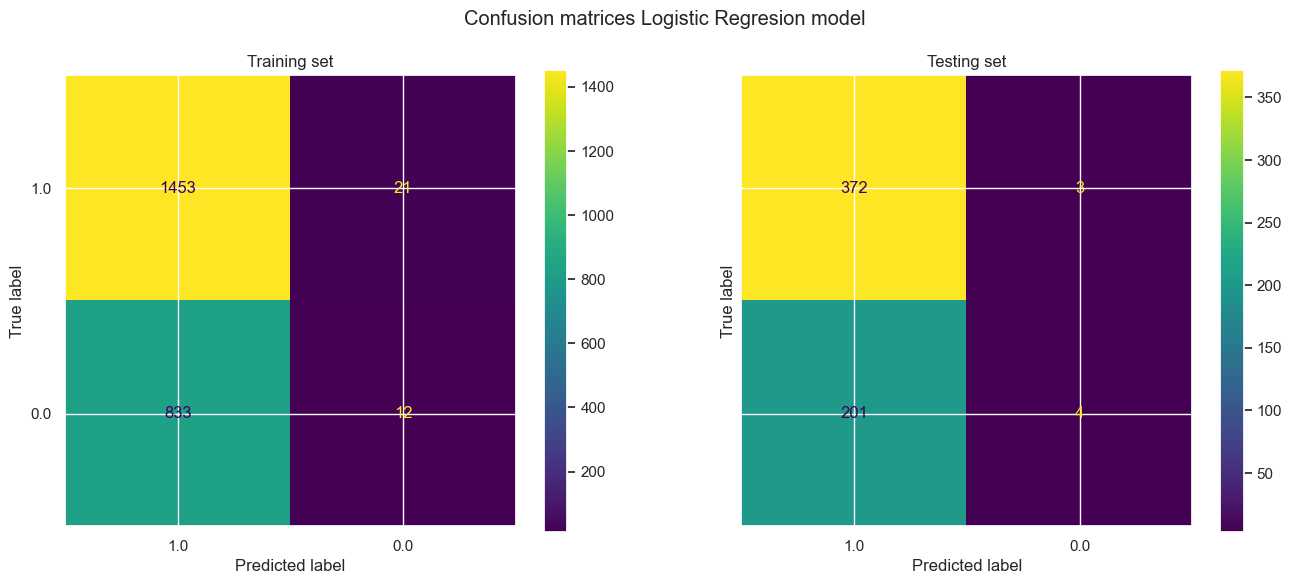

In [300]:
f, axes = plt.subplots(1, 2, figsize=(16, 6), sharey='row')

matrices = {
    "Training set": train_matrix,
    "Testing set": test_matrix
}

for i, (key, matrix) in enumerate(matrices.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix,
                                  display_labels=log_model.classes_[::-1])
    disp.plot(ax=axes[i])
    disp.ax_.set_title(key)

f.suptitle('Confusion matrices Logistic Regresion model')


**Comment**: The confusion matrix number also aggree with the our previous assumption, that is: The logistic model tends to predict a sample rating as **like**, therefore the *False Negative* figure is large for both train and test dataset.

### K-nearest Neighbors

#### Build and train the model

In [301]:
n_neighbors = 5

knn_model = KNeighborsClassifier(n_neighbors)
knn_model.fit(X_train, y_train)

print(knn_model.classes_)


[0. 1.]


#### Evaluate the model

In [ ]:
train_predicted = knn_model.predict(X_train)
test_predicted = knn_model.predict(X_test)

train_score = knn_model.score(X_train, y_train)
print("Accuracy score on training set: ",
      train_score)

accuracy_scores.append(['KNN', train_score, 'training'])

test_score = knn_model.score(X_test, y_test)
print("Accuracy score on testing set: ",
      test_score)
accuracy_scores.append(['KNN', test_score, 'testing'])


Accuracy score on training set:  0.7460112117291936
Accuracy score on testing set:  0.603448275862069


**Comment:** Accuracy score of KNN model is somewhat above average. This is the same case with the result of Logistic Regression model, because the correlation between features are low and the dataset is unbalanced.


The accuracy of KNN model on training set is slightly better than that of Logistic regresion model, at 0.746 of KNN and 0.631 of LogRegresion. However, accuracy on testing set of KNN is lower than the number achived by LR model, at 0.603 and 0.648 respectively.

In [ ]:
accuracy_df = pd.DataFrame(accuracy_scores, columns=[
                           'model', 'accuracy', 'set'])
accuracy_df


,model,accuracy,set
0,Logistic Regresion,0.631738,training
1,Logistic Regresion,0.648276,testing
2,KNN,0.746011,training
3,KNN,0.603448,testing


Text(0.5, 1.0, 'Accuracy comparision for 2 models')

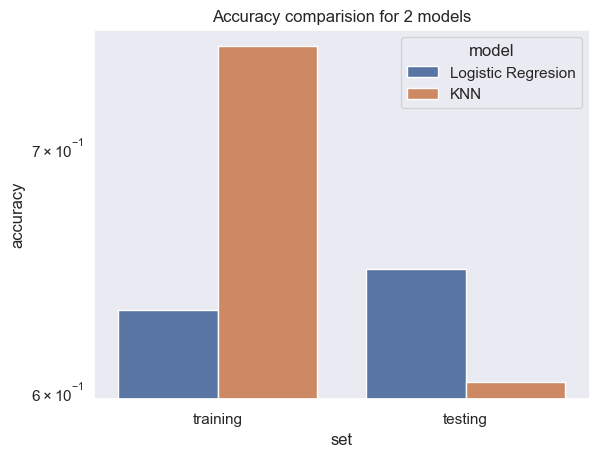

In [ ]:
acc_plot = sns.barplot(data=accuracy_df, x='set', y='accuracy', hue='model')
acc_plot.set_yscale("log")
acc_plot.set_title('Accuracy comparision for 2 models')


#### Confusion Matrix

In [ ]:
# Checking confusion matrix
print("Confusion matrix on train set: ")
train_matrix = confusion_matrix(y_train, train_predicted,
                                labels=log_model.classes_[::-1])
print(train_matrix)


Confusion matrix on train set: 
[[1256  218]
 [ 371  474]]


In [ ]:
print("Confusion matrix on test set: ")
test_matrix = confusion_matrix(y_test, test_predicted,
                               labels=log_model.classes_[::-1])
print(test_matrix)

Confusion matrix on test set: 
[[275 100]
 [130  75]]


**Comment:** This is the same case with Logistic Regresion model , the **False Negative** predictions is relatively large. This is as expected since the dataset is unbalanced and the correlations of features are low.

### Tune the K parameter in KNN

In [ ]:
# create score df for different K
n_neighbors = []
for i in range(1, 100):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(X_train, y_train)
    n_neighbors.append([i, model.score(X_train, y_train), 'train'])
    n_neighbors.append([i, model.score(X_test, y_test), 'test'])

neighbors_df = pd.DataFrame(
    n_neighbors, columns=['K', 'accuracy', 'set'])
neighbors_df.head()


,K,accuracy,set
0,1,0.999138,train
1,1,0.613793,test
2,2,0.800776,train
3,2,0.527586,test
4,3,0.802501,train


Text(0.5, 1.0, 'Accuracy of KNN model changes by parameter K')

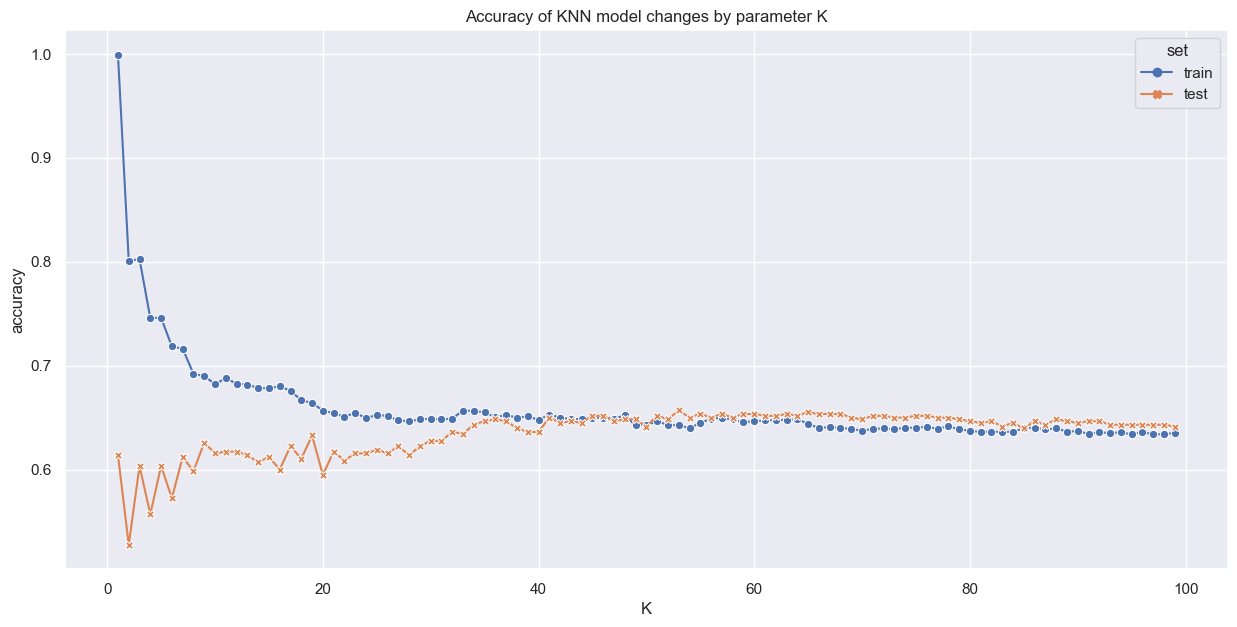

In [ ]:
plt.figure(figsize=[15, 7])
sns.lineplot(data=neighbors_df, x='K', y='accuracy', hue='set', style='set',
             markers=True, dashes=False).set_title('Accuracy of KNN model changes by parameter K')


**Comment**: While training accuracy reduce when K are low to higher K, the opposite case happen with testing accuracy. Testing score slightly increase from when K have lower values to higher values. The two accuracy of model on train and test set slowly converge at around K=30. Then, there is no significant changes in accuracy score on both training and testing set.


The highest accuracy score on test set appear to be around K = 50.

#### Automatic hyperparameter K tuning


In [ ]:
# Define search space for parameters
parameter_grid = {'n_neighbors': range(1, 100)}

# Create the machine learning model
knn_clf = KNeighborsClassifier()
clf = GridSearchCV(knn_clf, parameter_grid, scoring='accuracy', cv=10)
clf.fit(df[input_features], df[target_feature])

# Identify the best parameter(s)
print('Best K value: ', clf.best_params_['n_neighbors'])
print('The accuracy: ', clf.best_score_)

Best K value:  76
The accuracy:  0.6388461997375015


**Comment:** Using automatic tunning give best K value of 76, with the accuracy score around 0.64. As stated from the begining, this accuracy score is due to the dataset is unbalanced, and the correlation between features are low. Therefore, the model appear to not make good prediction on unforseen data.